In [1]:
import requests
import os
import yaml
os.chdir('../')

In [2]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
params = {'legend.fontsize': 14,
          'figure.figsize': (15, 8),
         'axes.labelsize': 14,
         'axes.titlesize': 14,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14}
plt.rcParams.update(params)
pd.options.display.max_columns = 50
pd.options.display.precision = 2

In [4]:
from cloudant.view import View
from cloudant.client import Cloudant
from cloudant.document import Document

In [5]:
def unfold_keys(df):
    df = df.copy()
    key_column = 'key'
    for i in range(0, len(df.loc[0,key_column])):
        df.insert(i, 'level_{}'.format(i+1), df[key_column].apply(lambda x: x[i]))
    del df[key_column]
    return df

In [6]:
with open("config.yaml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

In [7]:
cfg = cfg['COUCHDB']
client = Cloudant(cfg['user'], cfg['password'], url=cfg['host'])
client.connect()
tweets_db = client[cfg['tweets_db']]
aurin_db = client[cfg['aurin_db']]
ddoc = Document(tweets_db, '_design/sentiment_analysis')

In [8]:
view = View(ddoc, 'geo_sentiment_counts', )
with view.custom_result(group=True, stale='update_after', descending=True) as rslt:
    df = pd.DataFrame.from_records(rslt.all())

In [9]:
geo_sentiment_columns = ['sa4_area', 'gccsa_area', 'state', 'sentiment', 'tweets_count']
data_df = unfold_keys(df)
data_df.dropna(inplace=True)
data_df.columns = geo_sentiment_columns
data_df.sort_values('tweets_count', ascending=False, inplace=True)

In [10]:
data_df.set_index(geo_sentiment_columns[:-1], inplace=True)

In [11]:
sentiment_df = data_df.unstack(level=-1, fill_value=0)

In [12]:
#data_df.head()

In [28]:
data = [item['properties'] for item in aurin_db['GCCSA_median_income']['features']]

In [29]:
pd.DataFrame.from_records(data)

,gcc_code16,gcc_name16,median_tot_fam_inc_weekly,median_tot_hhd_inc_weekly,median_tot_prsnl_inc_weekly
0,1GSYD,Greater Sydney,1988,1750,719
1,1RNSW,Rest of NSW,1449,1168,584
2,2GMEL,Greater Melbourne,1826,1542,673
3,2RVIC,Rest of Vic.,1418,1124,576
4,3GBRI,Greater Brisbane,1821,1562,703
5,3RQLD,Rest of Qld,1511,1271,624
6,4GADE,Greater Adelaide,1591,1265,617
7,4RSAU,Rest of SA,1307,1027,550
8,5GPER,Greater Perth,1955,1643,728
9,5RWAU,Rest of WA,1730,1415,713


In [34]:
sentiment_df = sentiment_df.groupby(level='gccsa_area').sum()
sentiment_df.columns = sentiment_df.columns.droplevel(0)
sorted_columns = list(sentiment_df.sum().sort_values(ascending=False).index.values)
sentiment_df = sentiment_df[sorted_columns]

# Sentiment By States

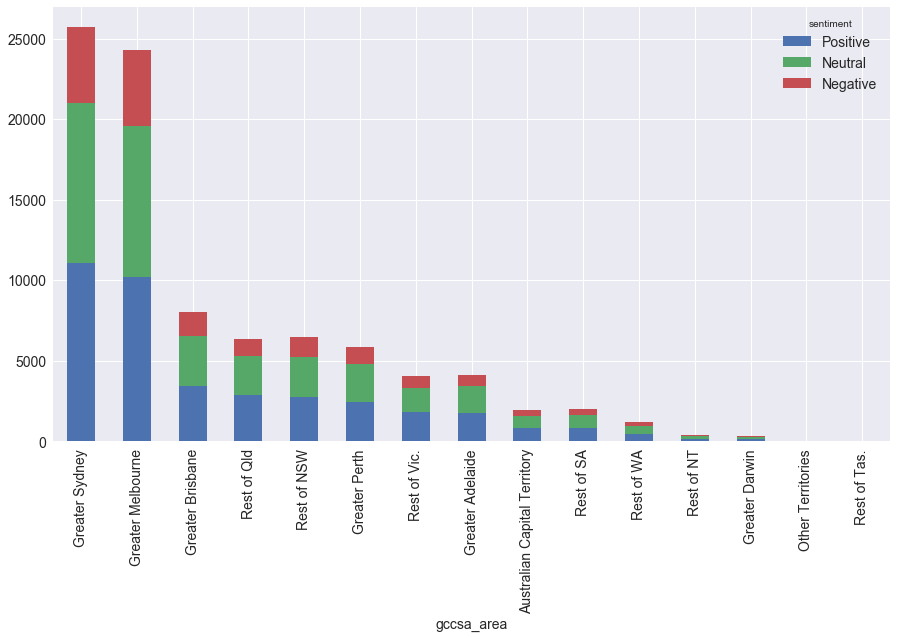

In [30]:
plot_df.sort_values('Positive', ascending=False, inplace=True)
plot_df.plot.bar(stacked=True)
plt.show()

In [31]:
totals = plot_df.sum(axis=1)
for idx in plot_df.index.values:
    plot_df.loc[idx] = plot_df.loc[idx] / totals.loc[idx] * 100

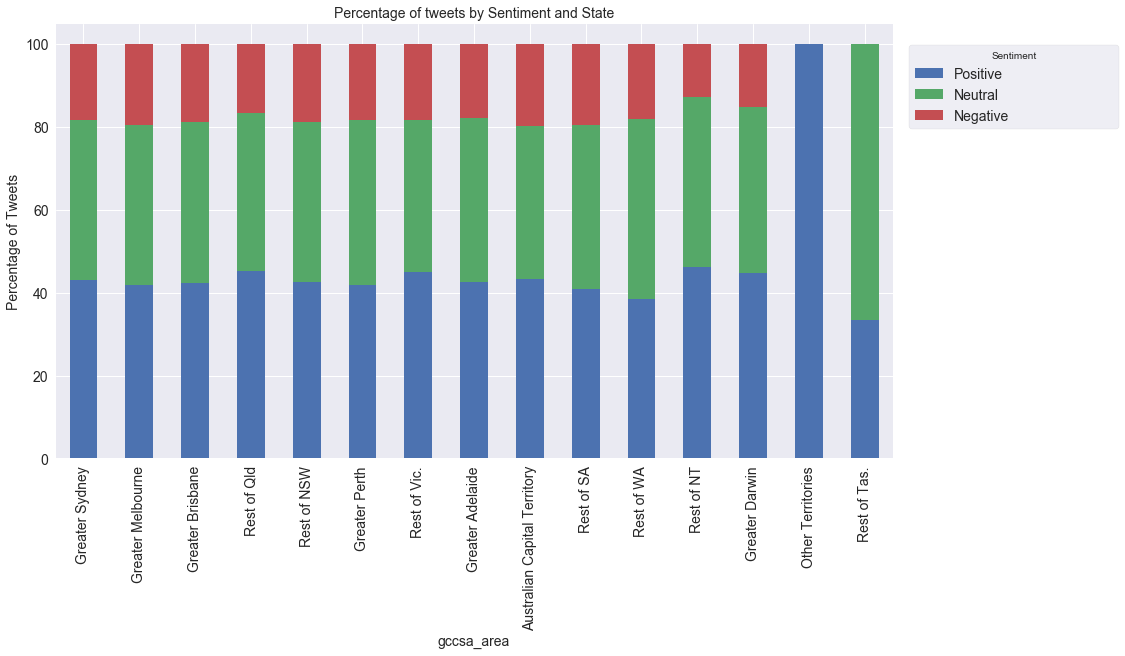

sentiment,Positive,Neutral,Negative
gccsa_area,,,
Greater Sydney,43%,39%,18%
Greater Melbourne,42%,39%,19%
Greater Brisbane,42%,39%,19%
Rest of Qld,45%,38%,17%
Rest of NSW,43%,38%,19%
Greater Perth,42%,40%,18%
Rest of Vic.,45%,37%,18%
Greater Adelaide,43%,40%,18%
Australian Capital Territory,43%,37%,20%


In [32]:
plot_df.plot.bar(stacked=True)
ax = plt.gca()
ax.legend(frameon=True, loc=2, bbox_to_anchor=(1.02, 0.0,.25, .95), mode='expand', borderaxespad=0.,
                      title='Sentiment')
ax.set_title('Percentage of tweets by Sentiment and State')
ax.set_ylabel('Percentage of Tweets')
plt.show()
plot_df.applymap(lambda x: '{:.0f}%'.format(x))